# Install Important Libraries

In [ ]:
!pip install  tensorflow-gpu==2.0.0
!pip install keras==2.3.1
!pip uninstall -y h5py
!pip install 'h5py < 3.0.0'

     |████████████████████████████████| 380.8 MB 40 kB/s 
     |████████████████████████████████| 3.8 MB 33.5 MB/s 
     |████████████████████████████████| 50 kB 3.3 MB/s 
     |████████████████████████████████| 449 kB 35.2 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=95b3b19e87de0ff7607f10d504ba99ff45d00b226aa72465be538597fe9d2bb1
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      Succes

# Import Required Libraries

In [ ]:
import tensorflow as tf
import os
import cv2
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.compat.v1.Session(config=config)
from keras import backend as K


import xgboost as xgb
from datetime import datetime
import keras
from keras.utils import np_utils
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, LSTM
from tensorflow.keras import models
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, SeparableConv2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.layers import PReLU,LeakyReLU
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import TensorBoard

# Declare Variables

In [ ]:
# Set Image height and Weight
imgRows=224
imgCols=224
#Set the numChannel to 1 for grayscale Image and 3 for Color Image
numChannel=3
# Number of iteration
numEpoch=100
# Number of data point for each pass
batchSize=100
#Get the current Working Directory
currPath = os.getcwd()
currPath = currPath.replace('\\','/')
# Define training, testing, and Log Dir
trainDir = currPath+'/drive/MyDrive/Dataset_Task3/training'
testDir = currPath+'/drive/MyDrive/Dataset_Task3/testing' 
logDir = currPath+'/drive/MyDrive/Dataset_Task3/Log/' + datetime.now().strftime("%Y%m%d-%H%M%S")


# Initialize Functions

In [ ]:
import itertools 
# Plotting the confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Data Ingestion_PreProcessing

##Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
trainListDirs = os.listdir(trainDir)
# get number of classes based on the directory count
numClasses = len(trainListDirs)

# Create empty list for loading data
imgDataList = []

# Traverse through the training data for loading it to memory
for classDir in trainListDirs:
    imgList = os.listdir(trainDir+'/'+ classDir)
#   Read image from the directory
    print ('Loading the images of Class-'+'{}\n'.format(classDir))
#     Read all images of each class
    for img in imgList:
        input_img=cv2.imread(trainDir + '/'+ classDir + '/'+ img)
        if numChannel == 3:
#             Convert the image to RGB
            input_img = cv2.cvtColor(input_img,cv2.COLOR_BGR2RGB)
        else:
#             Convert the image to grayscale
            input_img = cv2.cvtColor(input_img,cv2.COLOR_BGR2GRAY)
#     Resize the image with given dimension
        newImgResize = cv2.resize(input_img,(imgRows,imgCols), interpolation = cv2.INTER_AREA)
#     Append the image to the List and load it to the memory
        imgDataList.append(newImgResize)

Loading the images of Class-industrial

Loading the images of Class-Office

Loading the images of Class-bedroom

Loading the images of Class-Mountain

Loading the images of Class-Coast

Loading the images of Class-Insidecity

Loading the images of Class-Forest

Loading the images of Class-Highway

Loading the images of Class-livingroom

Loading the images of Class-kitchen

Loading the images of Class-OpenCountry

Loading the images of Class-TallBuilding

Loading the images of Class-Suburb

Loading the images of Class-store

Loading the images of Class-Street



In [ ]:
# Typecast the image to numpy array for vectorizing the data
imgData = np.array(imgDataList)
imgData = imgData.astype('float32')
# Normalize the data
imgData /= 255

#  Format the data according to tf format
if numChannel == 1 :
  imgData= np.expand_dims(imgData, axis=-1) 
  print (imgData.shape)


#### Assign Labels to data

In [ ]:
# Apply Label Encoding
labels = np.ones((imgData.shape[0],),dtype='int64')
initLabelRange = 0
for i in range(numClasses):
    finalLabelRange = len(os.listdir(trainDir+'/'+ trainListDirs[i]))+initLabelRange
    labels[initLabelRange:finalLabelRange]=i
    initLabelRange = finalLabelRange

## Encode Label and Split Data into Training and Testing

In [ ]:
# convert class labels to on-hot encoding
Y = np_utils.to_categorical(labels, numClasses)

#Shuffle the dataset
x,y = shuffle(imgData, Y, random_state=42)
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# ML Model

## Model Definition

In [ ]:
# Get shape of the data
input_shape = imgData[0].shape
                    
inputimg = Input(shape=input_shape)

def Model_Custom1(inputimg):
    # First Block
    conv1_1=Conv2D(16,(3,3), padding='same', activation='relu')(inputimg)
    conv1_2=Conv2D(32,(5,5), padding='same', activation='relu')(conv1_1)
    conv1=Conv2D(32,(5,5), padding='same', activation='relu')(conv1_2)

    # Second Block
    conv2_1=Conv2D(16,(5,5), padding='same', activation='relu')(inputimg)
    conv2_2=Conv2D(32,(7,7), padding='same', activation='relu')(conv2_1)
    maxpool_conv2=MaxPooling2D((2,2),strides=(1,1),padding='same')(conv2_2)
    
    # Third Block
    conv3=MaxPooling2D((2,2),strides=(1,1),padding='same')(inputimg)
    conv3=Conv2D(32,(5,5),padding='same',activation='relu')(conv3)
    bn_conv3=BatchNormalization()(conv3)
    
    conv_concat=keras.layers.concatenate([conv1,maxpool_conv2], axis = 3)

    bn_convcat=BatchNormalization()(conv_concat)
    
    conv4_maxpool_conv3_concat=keras.layers.concatenate([bn_conv3,bn_convcat], axis = 3)
    
    conv4=Conv2D(32,(5,5),padding='same',activation='relu')(bn_convcat)
    
    maxpool_conv4=MaxPooling2D((2,2),strides=(1,1),padding='same')(conv4)
    
    bn_maxpool_conv4=BatchNormalization()(maxpool_conv4)
    
    return bn_maxpool_conv4

def Model_CustomPretrainedResnet(inputimg):
  # Define the resnet model without top layer
  model = ResNet50(input_tensor= inputimg , include_top=False, weights='imagenet',
                   input_shape=input_shape)
  
  # Freeze specific layers
  for layer in model.layers[:143]:
        layer.trainable = False

  return model.output

def Model_CustomPretrainedVGG16(inputimg):
  # Define the VGG16 model without top layer
  model = VGG16(input_tensor= inputimg , include_top=False, weights='imagenet',
                   input_shape=input_shape)

  # Freeze four convolution blocks
  for layer in model.layers[:15]:
      layer.trainable = False
  # Make sure you have frozen the correct layers
  for i, layer in enumerate(model.layers):
      print(i, layer.name, layer.trainable)

  return model.output

def Last_layer(input_layer):
    
    conv_concat_flatten = Flatten()(input_layer)
    dense_layer_1 = Dense(512,activation='relu')(conv_concat_flatten)
    bn_dense_layer_1 = BatchNormalization()(dense_layer_1)

    dense_layer_2 = Dense(256,activation='relu')(bn_dense_layer_1)
    bn_dense_layer_2 = BatchNormalization()(dense_layer_2)

    dense_layer_3=Dense(80,activation='relu')(bn_dense_layer_2)
    
    bn_dense_layer_3=BatchNormalization()(dense_layer_3)

    dense_layer_4=Dense(20,activation='relu')(bn_dense_layer_3)
    
    bn_dense_layer_4=BatchNormalization()(dense_layer_4)
    
    return bn_dense_layer_4


layer_loop1=Model_CustomPretrainedVGG16(inputimg)

final_layer=Last_layer(layer_loop1)

final=Dense(y_train.shape[1], activation='softmax')(final_layer)
model=Model([inputimg],final)

plot_model(model,to_file='model.png',show_shapes=True, show_layer_names=True)
learningRate = 5e-5
model.compile(optimizer = 'adam',loss = 'categorical_crossentropy',metrics = ['accuracy'])

# Viewing model_configuration

# model.summary()

0 input_3 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [ ]:
# Remove existing Log if present
%rm -rf './log'

## Model Training

In [ ]:
# Create model checkpoint for saving only the best model with least validation loss
model_checkpoint = ModelCheckpoint('modelTaskVGG16.h5', monitor='val_loss', verbose=1, save_best_only=True)
# Initializae tensorboard for callback to inspect logs generated
tensorboardCall = TensorBoard(
  log_dir=logDir,
  histogram_freq=1,
  write_images=True)
# Below callback was tried to avoid overfitting
LROnPlateauCallback = ReduceLROnPlateau(monitor='val_loss', factor=0.6, patience=8, verbose=1, mode='max', min_lr=5e-5)
# Train the model with specified parameters
hist = model.fit(X_train, y_train, batch_size=batchSize, epochs=numEpoch, verbose=1, validation_data=(X_test, y_test),callbacks=[ tensorboardCall, model_checkpoint])

Train on 1200 samples, validate on 300 samples
Epoch 1/100
1100/1200 [==========================>...] - ETA: 1s - loss: 0.1295 - accuracy: 0.9991
Epoch 00001: val_loss improved from inf to 1.05444, saving model to modelTaskVGG16.h5
1200/1200 [==============================] - 19s 16ms/sample - loss: 0.1281 - accuracy: 0.9992 - val_loss: 1.0544 - val_accuracy: 0.7400
Epoch 2/100
1100/1200 [==========================>...] - ETA: 1s - loss: 0.1090 - accuracy: 1.0000
Epoch 00002: val_loss improved from 1.05444 to 0.94869, saving model to modelTaskVGG16.h5
1200/1200 [==============================] - 19s 15ms/sample - loss: 0.1099 - accuracy: 1.0000 - val_loss: 0.9487 - val_accuracy: 0.7533
Epoch 3/100
1100/1200 [==========================>...] - ETA: 1s - loss: 0.0912 - accuracy: 1.0000
Epoch 00003: val_loss improved from 0.94869 to 0.91983, saving model to modelTaskVGG16.h5
1200/1200 [==============================] - 19s 16ms/sample - loss: 0.0944 - accuracy: 0.9992 - val_loss: 0.9198 - 

### Save Model and Weights

In [ ]:
# Save the model for later testing
from keras.models import model_from_json
from keras.models import load_model
# serialize model to JSON
model_json = model.to_json()
with open("modelVGG16.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("modelVGG16",save_format='tf')
print("Saved model to disk")
model.save('testModel.h5')

Saved model to disk


[INFO] loading network...
Loaded model from disk
Accuracy =  0.7633333333333333


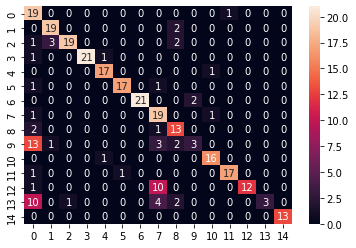

In [ ]:
XGBmodel = xgb.XGBClassifier()
from tensorflow.keras.models import load_model
from keras.models import model_from_json

# Load Trained CNN Model
print("[INFO] loading network...")
loaded_model =  tf.keras.models.load_model('testModel.h5')


# json_file = open('modelVGG16.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# loaded_model = model_from_json(loaded_model_json)
# # load weights into new model
# loaded_model.load_weights("modelVGG16")
print("Loaded model from disk")

xgbX_predict = loaded_model.predict(X_train)
xgbX_trainFeatures = xgbX_predict.reshape(xgbX_predict.shape[0], -1)

XGBmodel.fit(xgbX_trainFeatures,y_train.argmax(1)) #For sklearn no one hot encoding

#Send test data through same feature extractor process
xgbX_predict = loaded_model.predict(X_test)
xgbX_predict = xgbX_predict.reshape(xgbX_predict.shape[0], -1)

#Now predict using the trained RF model. 
prediction = XGBmodel.predict(xgbX_predict)

#Print overall accuracy
from sklearn import metrics
print ("Accuracy = ", accuracy_score(y_test.argmax(1), prediction))

#Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test.argmax(1), prediction)
sns.heatmap(cm, annot=True)



### Training Visualization

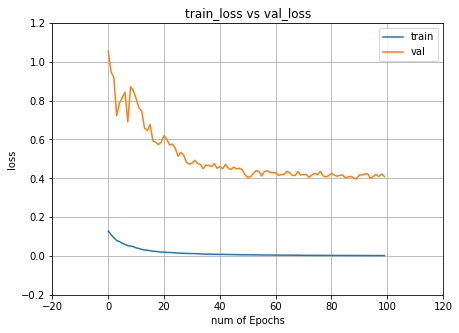

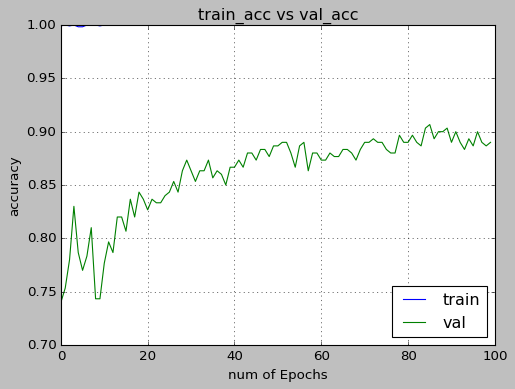

In [ ]:
## visualizing losses and accuracy
trainLoss=hist.history['loss']
valLoss=hist.history['val_loss']
trainAcc=hist.history['accuracy']
valAcc=hist.history['val_accuracy']
xc=range(numEpoch)

plt.figure(1,figsize=(7,5))
plt.plot(xc,trainLoss)
plt.plot(xc,valLoss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
#print(plt.style.available) # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])
plt.savefig("train_val_loss_ver.png")

plt.figure(2,figsize=(7,5))
plt.plot(xc,trainAcc)
plt.plot(xc,valAcc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])
plt.savefig("train_val_acc_ver.png")

Confusion matrix, without normalization


<Figure size 1920x1920 with 0 Axes>

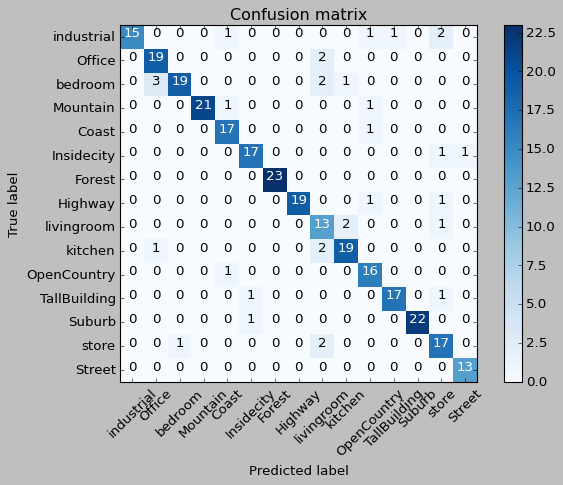

In [ ]:
Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)
targetNames = trainListDirs
# Compute confusion matrix
cnf_matrix = (confusion_matrix(np.argmax(y_test, axis=1), y_pred))

np.set_printoptions(precision=2)
#change fig size to change size of the Confusion matrix
plt.figure(figsize=(24, 24))
plt.figure()

# Plot non-normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=targetNames, title='Confusion matrix')
plt.savefig("Confusion Matrix.png")
plt.show()

In [ ]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss:', score[0])
print('Test accuracy:', score[1])

Test Loss: 0.40880467573801677
Test accuracy: 0.89


#For testing

In [ ]:
import tensorflow as tf
import os
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from keras.models import model_from_json
from tqdm import tqdm

import re
def sorted_alphanumeric(data):
  convert = lambda text: int(text) if text.isdigit() else text.lower()
  alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
  return sorted(data, key=alphanum_key)
                  


# Set Image height and Weight
imgRows=224
imgCols=224
#Set the numChannel to 1 for grayscale Image and 3 for Color Image
numChannel=3


#Get the current Working Directory
currPath = os.getcwd()
currPath = currPath.replace('\\','/')

# Define training, testing, and Log Dir
trainDir = currPath+'/drive/MyDrive/Dataset_Task3/training'
testDir = currPath+'/drive/MyDrive/Dataset_Task3/testing'

# Load Trained CNN Model
print("[INFO] loading network...")
loaded_model =  tf.keras.models.load_model(currPath+'/drive/MyDrive/Dataset_Task3/testModel.h5')
print("Loaded model from disk")
# loaded_model.predict(X_test)


# The variable will have all the class names
trainListDirs = os.listdir(trainDir)
# This variable will have all the testing images
imgListDirs = sorted_alphanumeric(np.sort(os.listdir(testDir)))

trainListDirs = os.listdir(trainDir)
# get number of classes based on the directory count
numClasses = len(trainListDirs)

# Create empty list for loading data
imgDataList = []

fileRun3 = open('run3.txt', 'w+')
#     Read all images of each class
for filePos,img in tqdm(enumerate(imgListDirs)):
    input_img=cv2.imread(testDir+ '/'+ img)
    if numChannel == 3:
#             Convert the image to RGB
        input_img = cv2.cvtColor(input_img,cv2.COLOR_BGR2RGB)
    else:
#             Convert the image to grayscale
        input_img = cv2.cvtColor(input_img,cv2.COLOR_BGR2GRAY)
#     Resize the image with given dimension
    newImgResize = cv2.resize(input_img,(imgRows,imgCols), interpolation = cv2.INTER_AREA)
    newImgResize = newImgResize.astype('float32')
    finalImg = newImgResize/255
    finalImg=np.expand_dims(finalImg,axis=0)
    result=loaded_model.predict(finalImg)
    max=result[0][0]
    label=0
    for i in range(0,len(result[0])):
    	if result[0][i]>max:
    		max=result[0][i]
    		label=i
    fileRun3.write(f"{imgListDirs[filePos]} {trainListDirs[label]}\n")
fileRun3.close()

[INFO] loading network...
Loaded model from disk


2985it [05:27,  9.11it/s]
